In [1]:
from sklearn.model_selection import train_test_split
from  sklearn.model_selection import GridSearchCV
from sklearn import metrics,ensemble
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [3]:
# Load training data
df = pd.read_csv('D:/secondterm/6010S/project/train.csv')

# 2% sample of items
df = df.sample(frac=0.02)

In [4]:
# Load and merge songs data
songs = pd.read_csv('D:/secondterm/6010S/project/songs.csv')
df = pd.merge(df, songs, on='song_id', how='left')
del songs

# Load and merge songs data
members = pd.read_csv('D:/secondterm/6010S/project/members.csv')
df = pd.merge(df, members, on='msno', how='left')
del members

In [5]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 147548 entries, 0 to 147547
Data columns (total 18 columns):
msno                      147548 non-null object
song_id                   147548 non-null object
source_system_tab         147044 non-null object
source_screen_name        139317 non-null object
source_type               147110 non-null object
target                    147548 non-null int64
song_length               147540 non-null float64
genre_ids                 145104 non-null object
artist_name               147540 non-null object
composer                  113845 non-null object
lyricist                  83867 non-null object
language                  147539 non-null float64
city                      147548 non-null int64
bd                        147548 non-null int64
gender                    88549 non-null object
registered_via            147548 non-null int64
registration_init_time    147548 non-null int64
expiration_date           147548 non-null int64
dtypes: float

In [6]:
# Replace NA
for i in df.select_dtypes(include=['object']).columns:
    df[i][df[i].isnull()] = 'unknown'
df = df.fillna(value=0)

In [7]:
# Create Dates

# registration_init_time
df.registration_init_time = pd.to_datetime(df.registration_init_time, format='%Y%m%d', errors='ignore')
df['registration_init_time_year'] = df['registration_init_time'].dt.year
df['registration_init_time_month'] = df['registration_init_time'].dt.month
df['registration_init_time_day'] = df['registration_init_time'].dt.day

# expiration_date
df.expiration_date = pd.to_datetime(df.expiration_date,  format='%Y%m%d', errors='ignore')
df['expiration_date_year'] = df['expiration_date'].dt.year
df['expiration_date_month'] = df['expiration_date'].dt.month
df['expiration_date_day'] = df['expiration_date'].dt.day

In [8]:
# Dates to category
df['registration_init_time'] = df['registration_init_time'].astype('category')
df['expiration_date'] = df['expiration_date'].astype('category')


In [9]:
# Object data to category
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].astype('category')
    
# Encoding categorical features
for col in df.select_dtypes(include=['category']).columns:
    df[col] = df[col].cat.codes

In [10]:
df.corr()

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,...,gender,registered_via,registration_init_time,expiration_date,registration_init_time_year,registration_init_time_month,registration_init_time_day,expiration_date_year,expiration_date_month,expiration_date_day
msno,1.000000,-0.000324,0.009123,-0.002968,-0.001789,0.000229,0.002940,0.002110,0.003974,0.004971,...,-0.007804,0.002677,0.001431,0.008194,0.000882,0.010459,0.007726,-0.000872,0.011427,0.001022
song_id,-0.000324,1.000000,-0.005127,0.004327,0.005767,-0.004478,-0.007740,0.007333,-0.015087,-0.034742,...,0.001179,-0.004922,0.001411,-0.004145,0.002361,-0.005362,-0.002748,-0.000961,-0.004355,0.001169
source_system_tab,0.009123,-0.005127,1.000000,-0.033404,-0.080197,0.027320,0.021526,0.036387,0.036805,0.051094,...,-0.029012,0.033846,-0.041442,0.050585,-0.037860,-0.013461,0.004084,0.032677,0.017675,0.008526
source_screen_name,-0.002968,0.004327,-0.033404,1.000000,0.414838,-0.057003,0.023139,-0.014885,0.011991,0.021432,...,0.017653,-0.029290,0.035032,-0.035606,0.033282,0.004178,-0.004776,-0.028200,-0.005085,0.004415
source_type,-0.001789,0.005767,-0.080197,0.414838,1.000000,-0.131737,0.016516,-0.049332,-0.018368,-0.001261,...,0.026725,-0.025346,0.032366,-0.046959,0.029977,0.007297,-0.001358,-0.041019,0.001310,-0.006970
target,0.000229,-0.004478,0.027320,-0.057003,-0.131737,1.000000,0.000532,0.013257,0.008900,-0.001314,...,-0.014445,0.008630,-0.004161,0.056990,-0.003474,-0.003988,-0.005770,0.041239,0.013079,0.004900
song_length,0.002940,-0.007740,0.021526,0.023139,0.016516,0.000532,1.000000,0.023886,0.112416,0.092910,...,0.002446,0.000042,-0.003893,0.006832,-0.004728,0.005588,-0.002835,0.003210,0.004831,0.001130
genre_ids,0.002110,0.007333,0.036387,-0.014885,-0.049332,0.013257,0.023886,1.000000,0.192251,0.143843,...,-0.007824,0.007590,-0.006184,0.006026,-0.006625,0.001617,-0.000318,0.009543,-0.010579,0.001467
artist_name,0.003974,-0.015087,0.036805,0.011991,-0.018368,0.008900,0.112416,0.192251,1.000000,0.346147,...,-0.002498,0.002162,-0.005375,0.009275,-0.005898,0.005495,-0.004202,0.007663,-0.000605,0.002845
composer,0.004971,-0.034742,0.051094,0.021432,-0.001261,-0.001314,0.092910,0.143843,0.346147,1.000000,...,-0.000561,0.001989,-0.003856,0.002937,-0.004950,0.007580,-0.003202,0.002683,0.000092,-0.000066


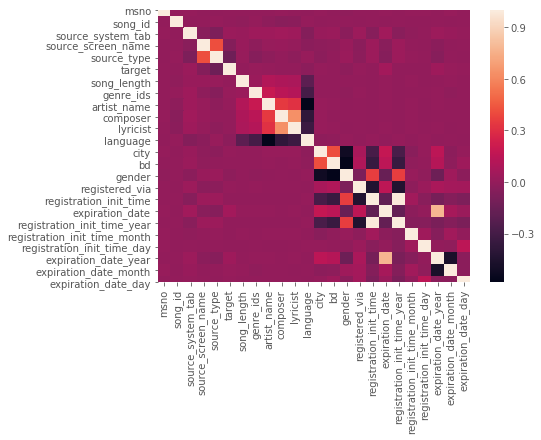

In [11]:
# Сorrelation matrix
plt.figure(figsize=[7,5])
sns.heatmap(df.corr())
plt.show()

In [12]:
# Drop columns
df = df.drop(['expiration_date', 'registration_init_time'], 1)

# Random Foreast
selected the most informative columns using Random Forest Model.

In [13]:
# Model with the best estimator
model1 = ensemble.RandomForestClassifier(n_estimators=250, max_depth=25)
model1.fit(df[df.columns[df.columns != 'target']], df.target)

RandomForestClassifier(max_depth=25, n_estimators=250)

In [14]:
df_plot = pd.DataFrame({'features': df.columns[df.columns != 'target'],
                        'importances': model1.feature_importances_})
df_plot = df_plot.sort_values('importances', ascending=False)

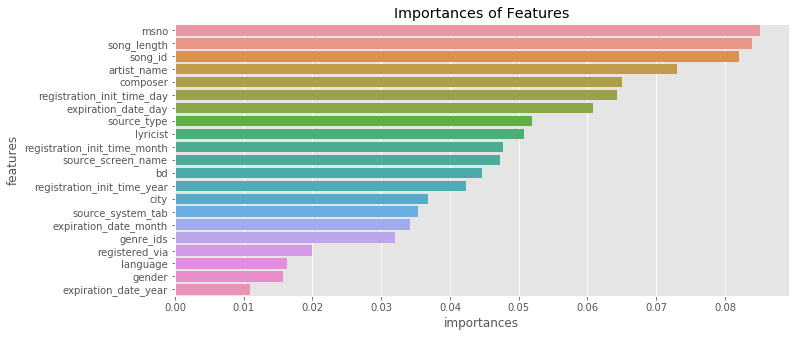

In [15]:
plt.figure(figsize=[11,5])
sns.barplot(x = df_plot.importances, y = df_plot.features)
plt.title('Importances of Features')
plt.show()

In [16]:
model1.feature_importances_

array([0.0850187 , 0.08209603, 0.03531785, 0.04721123, 0.05198099,
       0.08391622, 0.03194884, 0.07299942, 0.06506612, 0.05081249,
       0.01622624, 0.03678054, 0.04462822, 0.01575137, 0.01994574,
       0.04230002, 0.04772408, 0.06434824, 0.01088933, 0.0342193 ,
       0.06081902])

In [17]:
# Drop columns with importances < 0.04
df = df.drop(df_plot.features[df_plot.importances < 0.04].tolist(), 1)
# Selected columns
list(df.columns)

['msno',
 'song_id',
 'source_screen_name',
 'source_type',
 'target',
 'song_length',
 'artist_name',
 'composer',
 'lyricist',
 'bd',
 'registration_init_time_year',
 'registration_init_time_month',
 'registration_init_time_day',
 'expiration_date_day']

# XGboost


In [18]:
# split train and test set
target = df.pop('target')
train_data, test_data, train_labels, test_labels = train_test_split(df, target, test_size = 0.3)

In [20]:
#XGboost
xgmodel = xgb.XGBClassifier(learning_rate=0.1, max_depth=10, min_child_weight=10, n_estimators=250)
xgmodel.fit(train_data, train_labels)
xgpredict_labels = xgmodel.predict(test_data)
print(metrics.classification_report(test_labels, xgpredict_labels))

              precision    recall  f1-score   support

           0       0.65      0.60      0.62     21988
           1       0.63      0.68      0.65     22277

    accuracy                           0.64     44265
   macro avg       0.64      0.64      0.64     44265
weighted avg       0.64      0.64      0.64     44265



In [22]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score,precision_score,recall_score,roc_auc_score,accuracy_score,roc_curve

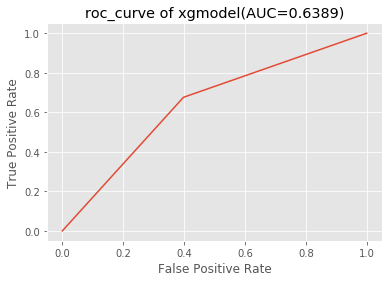

In [23]:
xgmodel_auc=roc_auc_score(test_labels,xgpredict_labels)
# print ROC curve
xgmodel_fpr,xgmodel_tpr,xgmodel_threasholds=roc_curve(test_labels,xgpredict_labels) 
plt.title("roc_curve of %s(AUC=%.4f)" %('xgmodel',xgmodel_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(xgmodel_fpr,xgmodel_tpr)
plt.show()


# Catboost

In [24]:
from catboost import CatBoostClassifier

In [25]:
model2 = CatBoostClassifier(learning_rate=0.1, max_depth=10,iterations=300)
model2.fit(train_data, train_labels)

0:	learn: 0.6850622	total: 226ms	remaining: 1m 7s
1:	learn: 0.6786175	total: 365ms	remaining: 54.3s
2:	learn: 0.6738821	total: 408ms	remaining: 40.4s
3:	learn: 0.6700364	total: 563ms	remaining: 41.6s
4:	learn: 0.6666232	total: 735ms	remaining: 43.3s
5:	learn: 0.6639393	total: 910ms	remaining: 44.6s
6:	learn: 0.6614662	total: 1.09s	remaining: 45.7s
7:	learn: 0.6591214	total: 1.28s	remaining: 46.8s
8:	learn: 0.6572161	total: 1.46s	remaining: 47.1s
9:	learn: 0.6556926	total: 1.63s	remaining: 47.4s
10:	learn: 0.6542444	total: 1.82s	remaining: 47.8s
11:	learn: 0.6531870	total: 1.98s	remaining: 47.5s
12:	learn: 0.6519312	total: 2.16s	remaining: 47.7s
13:	learn: 0.6507904	total: 2.31s	remaining: 47.2s
14:	learn: 0.6498558	total: 2.48s	remaining: 47.2s
15:	learn: 0.6490287	total: 2.66s	remaining: 47.2s
16:	learn: 0.6481740	total: 2.84s	remaining: 47.3s
17:	learn: 0.6474789	total: 3s	remaining: 47.1s
18:	learn: 0.6466987	total: 3.16s	remaining: 46.8s
19:	learn: 0.6459137	total: 3.32s	remaining:

In [26]:
predict_labels = model2.predict(test_data)
print(metrics.classification_report(test_labels, predict_labels))

              precision    recall  f1-score   support

           0       0.64      0.60      0.62     21988
           1       0.63      0.67      0.65     22277

    accuracy                           0.64     44265
   macro avg       0.64      0.64      0.64     44265
weighted avg       0.64      0.64      0.64     44265



In [27]:
predict_labels

array([1, 1, 1, ..., 0, 1, 0], dtype=int64)

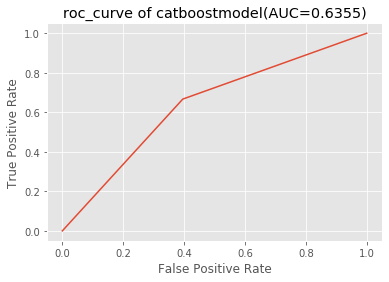

In [29]:
model2_auc=roc_auc_score(test_labels,predict_labels)
# print ROC curve
model2_fpr,model2_tpr,model2_threasholds=roc_curve(test_labels,predict_labels) 
plt.title("roc_curve of %s(AUC=%.4f)" %('catboostmodel',model2_auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(model2_fpr,model2_tpr)
plt.show()
